In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import h5py
from astropy.constants import M_sun
M_sun_g = M_sun.value*1e3
import pandas as pd
import glob as glob
import WinNet_output
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import random
import importlib
import sys
import yt
yt.set_log_level('ERROR')
import Snapshot2D
import WinNet_output

In [2]:
importlib.reload(Snapshot2D) #in order to not stop the kernel and still update the functionalities in case WinNet_object will be developed further
from Snapshot2D import Snapshot2D

In [3]:
importlib.reload(WinNet_output) #in order to not stop the kernel and still update the functionalities in case WinNet_object will be developed further
from WinNet_output import WinNet_output

# This is a (growing) collection of plots/... to analyze and visualize the results of postprocessing the nucleosynthesis done by WinNet

#### The analysis depends generally reads in the single directories with tracer, seed, mainout, finabs, ... for the single tracer winnet run with the class specified WinNet_output.
More on that in the README

#### This Notebook includes:

i) calculation and visualization of the composition of the entire ejected matter (weighted mass fraction/ summed up mass plotted against Z or A)

ii) Histograms to visualize the composition/.. of the ejected matter at NSE freeze out 

iii) Function to isolate and therefore analyse the  'neutrino processed' tracers (definition further down)

In [6]:
#first step: give path to the WinNet run and 'clean' them from failed calculations (due do negative expansion velocity/ end-temperature above winnet starting temp/ ....)
def file_has_data_quick(main_file, max_bytes=8192):
    with open(main_file, "rb") as f:
        chunk = f.read(max_bytes).decode(errors="ignore")
    for line in chunk.splitlines():
        line = line.strip()
        if not line.startswith("#") and line:
            return True
    return False

def clean_WinNet_run(path_to_workdir):
    cleaned_paths, skipped_err_dirs = [], []

    path_to_single_dirs = sorted([
        os.path.join(path_to_workdir, d)
        for d in os.listdir(path_to_workdir)
        if os.path.isdir(os.path.join(path_to_workdir, d))
    ])

    for path in tqdm(path_to_single_dirs):
        # 1. skip if ERR marker
        if os.path.isfile(os.path.join(path, "ERR")):
            skipped_err_dirs.append(path)
            continue

        # 2. check mainout.dat* exists and has data
        main_files = glob.glob(os.path.join(path, "mainout.dat*"))
        if not main_files or not file_has_data_quick(main_files[0]):
            skipped_err_dirs.append(path)
            continue

        # 3. check at least one tracer* file exists
        if not glob.glob(os.path.join(path, "tracer*.dat")):
            skipped_err_dirs.append(path)
            continue

        # 4. check WinNet_data*.h5 exists
        if not glob.glob(os.path.join(path, "WinNet_data*.h5")):
            skipped_err_dirs.append(path)
            continue

        cleaned_paths.append(path)

    return cleaned_paths, skipped_err_dirs

#### Read in tracer runs of S15 simulations

In [7]:
#2D 1ktr:

S15_1ktr_nf1_7GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_1ktr_nf1_7GK_oc'
S15_1ktr_nf1_7GK_clean, S15_1ktr_nf1_7GK_path_errdirs = clean_WinNet_run(S15_1ktr_nf1_7GK_path)

  0%|          | 0/2909 [00:00<?, ?it/s]

In [ ]:
#2D 10ktr
S15_10ktr_nf1_7GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10ktr_nf1_7GK_oc'
S15_10ktr_nf1_7GK_clean, S15_10ktr_nf1_7GK_path_errdirs = clean_WinNet_run(S15_10ktr_nf1_7GK_path)

  0%|          | 0/13439 [00:00<?, ?it/s]

In [ ]:
#2D 10ktr
S15_10ktr_nf1_15GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10ktr_nf1_15GK_oc'
S15_10ktr_nf1_15GK_clean, S15_10ktr_nf1_15GK_path_errdirs = clean_WinNet_run(S15_10ktr_nf1_15GK_path)

In [ ]:
#2D 10ktr
S15_10ktr_nf1_30GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_10ktr_nf1_30GK_oc'
S15_10ktr_nf1_30GK_clean, S15_10ktr_nf1_30GK_path_errdirs = clean_WinNet_run(S15_10ktr_nf1_30GK_path)

In [ ]:
#1D 750tr
S15_750tr_1D_nf1_7GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/S15_750tr_1D_nf1_7GK'
S15_750tr_1D_nf1_7GK_clean, S15_750tr_1D_nf1_7GK_errdirs = clean_WinNet_run(S15_750tr_1D_nf1_7GK_path)

In [ ]:
HeS_10ktr_nf1_7GK_path = '/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/HeS_BURN/10k_nf1_7GK_930ms_snap'
HeS_10ktr_nf1_7GK_clean, HeS_10ktr_nf1_7GK_errdirs = clean_WinNet_run(HeS_10ktr_nf1_7GK_path)

#### All further functions/ plotting cells etc. expect a cleaned list of output dirs

## 0) Ye deviation between tracers and WinNet -  aka. how good/precise/... is the set of tracers

In [ ]:
#functions to get delta ye between tracer and WinNet at a given temperature:

def find_last_fall_below(temps, t_crit):
    """
    Find the last index where temperature falls below t_crit.
    Returns the index where it falls below, or None if never falls below.
    """
    temps = np.asarray(temps)
    
    if len(temps) == 0:
        return None
    
    below = temps < t_crit
    
    if not np.any(below):
        #print('No entries below')
        return None
    
    # Find where it transitions from >= to 
    # diff will be True where temps[i] < t_crit AND temps[i-1] >= t_crit
    crossings = np.diff(below.astype(int)) == 1
    
    if np.any(crossings):
        return np.where(crossings)[0][-1] + 1  # +1 because diff reduces length by 1
    
    # If first value is already below, that's our answer
    return 0 if below[0] else None

def delta_Ye_at_T(clean_paths, T_crit):

    delta_yes = []
    paths = []
    tr_masses = []
    
    for path in tqdm(clean_paths):

        WN_out = WinNet_output(path, want_all =  True)

        T_crit_index_tr = find_last_fall_below(WN_out.tracer_data['temp'], T_crit)
        
        T_crit_index_mo = find_last_fall_below(WN_out.mainout_data['T'], T_crit)

        if T_crit_index_tr is not None and T_crit_index_mo is not None:
            ye_dev = np.abs(WN_out.tracer_data['ye'][T_crit_index_tr] - WN_out.mainout_data['Ye'][T_crit_index_mo])
    
            delta_yes.append(ye_dev)
            paths.append(path)
            tr_masses.append(WN_out.mass)

    return np.array(delta_yes), np.array(paths), np.array(tr_masses)


In [ ]:
S15_1ktr_delta_Yes_3GK = delta_Ye_at_T(S15_1ktr_nf1_7GK_clean, 3)

In [ ]:
S15_10ktr_delta_Yes_3GK = delta_Ye_at_T(S15_10ktr_nf1_7GK_clean, 3)

In [ ]:
S15_10ktr_delta_Yes_15GK_3GK = delta_Ye_at_T(S15_10ktr_nf1_15GK_clean, 3)

In [ ]:
S15_10ktr_delta_Yes_30GK_3GK = delta_Ye_at_T(S15_10ktr_nf1_30GK_clean, 3)

In [ ]:
#double histogram of ye deviation

#show t init impact:
deviations_to_plot = [S15_10ktr_delta_Yes_3GK[0], S15_10ktr_delta_Yes_15GK_3GK[0], S15_10ktr_delta_Yes_30GK_3GK[0]]
weights_numtr = [np.ones(len(S15_10ktr_delta_Yes_3GK[0]))/len(S15_10ktr_delta_Yes_3GK[0]),np.ones(len(S15_10ktr_delta_Yes_15GK_3GK[0]))/len(S15_10ktr_delta_Yes_15GK_3GK[0]), np.ones(len(S15_10ktr_delta_Yes_30GK_3GK[0]))/len(S15_10ktr_delta_Yes_30GK_3GK[0])]
weights_masses = [S15_10ktr_delta_Yes_3GK[2]/M_sun_g, S15_10ktr_delta_Yes_15GK_3GK[2]/M_sun_g, S15_10ktr_delta_Yes_30GK_3GK[2]/M_sun_g]
labels = [r'$T_\mathrm{init.}$=7GK', r'$T_\mathrm{init.}$=15GK', r'$T_\mathrm{init.}$=30GK']

fig, ax = plt.subplots(1,2, figsize = (12, 5))

#plt.suptitle('Ye diviation between tracer and WinNet at 3GK')
min = 0
max = 0.06

ax[0].hist(deviations_to_plot, range =(min, max),bins=20, weights = weights_numtr)
ax[0].set_yscale('log')
ax[0].set_ylabel('#/#$_\mathrm{Tr.}$', fontsize = 22)
ax[0].set_xlabel(r'|$Y_{e, Tr.}-Y_{e, WN}|$', fontsize = 22)
ax[0].tick_params(labelsize=18)

ax[1].hist(deviations_to_plot, range =(min, max), bins=20, weights =weights_masses, label = labels)
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$M_\mathrm{Tr.}$ [$M_\odot$]', fontsize = 22)
ax[1].set_xlabel(r'|$Y_{e, Tr.}-Y_{e, WN}$|', fontsize = 22)
ax[1].legend(fontsize=22)
ax[1].tick_params(labelsize=18)

plt.tight_layout()

In [ ]:
#double histogram of ye deviation

#show N tracer impact:
deviations_to_plot = [S15_1ktr_delta_Yes_3GK[0], S15_10ktr_delta_Yes_3GK[0]]
weights_numtr = [np.ones(len(S15_1ktr_delta_Yes_3GK[0]))/len(S15_1ktr_delta_Yes_3GK[0]), np.ones(len(S15_10ktr_delta_Yes_3GK[0]))/len(S15_10ktr_delta_Yes_3GK[0])]
weights_masses = [S15_1ktr_delta_Yes_3GK[2]/M_sun_g, S15_10ktr_delta_Yes_3GK[2]/M_sun_g]
labels = ['N3000', 'N13000']

fig, ax = plt.subplots(1,2, figsize = (12, 5))

#plt.suptitle('Ye diviation between tracer and WinNet at 3GK')
min = 0
max = 0.06

ax[0].hist(deviations_to_plot, range =(min, max),bins=20, weights = weights_numtr)
ax[0].set_yscale('log')
ax[0].set_ylabel('#/#$_\mathrm{Tr.}$', fontsize = 22)
ax[0].set_xlabel(r'|$Y_{e, Tr.}-Y_{e, WN}|$', fontsize = 22)
ax[0].tick_params(labelsize=18)

ax[1].hist(deviations_to_plot, range =(min, max), bins=20, weights =weights_masses, label = labels)
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$M_\mathrm{Tr.}$ [$M_\odot$]', fontsize = 22)
ax[1].set_xlabel(r'|$Y_{e, Tr.}-Y_{e, WN}$|', fontsize = 22)
ax[1].legend(fontsize=22)
ax[1].tick_params(labelsize=18)

plt.tight_layout()

## 1) Overall Ejecta Composition (X, Y, M_ej vs A/Z)

#### Function to sum up/average overall ejecta of all tracers

In [ ]:
def overall_composition_withsnaps(clean_path_to_WinNet_out, with_snapshots=False, nr_snapshots=None):
    """
    Compute mass-weighted, summed abundances across many WinNet tracer outputs.
    If with_snapshots=True also build the same weighted quantities for every
    snapshot that carries snapshot_composition data.
    Returns
    -------
    total_mass,
    (A_data, Z_data),                 # final abundances
    snapshot_data,                    # only if with_snapshots=True
    nr_snapshots                      # only if with_snapshots=True
    """
    # ----------------------------------------------------------
    # initialise final-abundance arrays
    # ----------------------------------------------------------
    all_Z = np.arange(0, 120, dtype=int)
    all_X_el = np.zeros(120)
    all_Y_el = np.zeros(120)
    all_M_el = np.zeros(120)

    all_A = np.arange(0, 240, dtype=int)          # index == mass number
    all_X = np.zeros(240)
    all_Y = np.zeros(240)
    all_M = np.zeros(240)

    # ----------------------------------------------------------
    # initialise snapshot buffers (only if requested)
    # ----------------------------------------------------------
    if with_snapshots:
        # we will accumulate *weighted* sums for every time step
        snapshot_sums = None          # dict  t -> {'X':..., 'Y':..., 'M':..., 'mass':0}
        unique_times  = None          # keeps order of appearance
    else:
        snapshot_sums = None
        unique_times  = None

    total_mass = 0.0
    masses     = []
    missing_snaptimes = []
    
    
    # ----------------------------------------------------------
    # loop over tracers
    # ----------------------------------------------------------
    for i, wn_out_path in tqdm(enumerate(clean_path_to_WinNet_out)):
        
        wn = WinNet_output(wn_out_path,
                           want_finabs_info=True,
                           want_tracer_info=True,
                           has_snapshots = with_snapshots)
        m = wn.mass
        masses.append(m)
        total_mass += m

        # ------------------------------------------------------
        # final abundances – already existing code
        # ------------------------------------------------------
        vals_A        = wn.finabsum["A"]
        all_X[vals_A] += wn.finabsum["X"] * m
        all_Y[vals_A] += wn.finabsum["Y"] * m
        all_M[vals_A] += wn.finabsum["X"] * m

        vals_Z          = wn.finabelem["Z"]
        all_X_el[vals_Z] += wn.finabelem["X"] * m
        all_Y_el[vals_Z] += wn.finabelem["Y"] * m
        all_M_el[vals_Z] += wn.finabelem["X"] * m

        # ------------------------------------------------------------------
        # inside overall_composition_withsnaps, snapshot section
        # ------------------------------------------------------------------
        if with_snapshots and hasattr(wn, 'snapshot_times'):
            # --- 1. first tracer sets the master time grid -----------------
            if unique_times is None:
                unique_times = wn.snapshot_times
                snapshot_sums = {t: {'X_A': np.zeros(240),
                                      'Y_A': np.zeros(240),
                                      'M_A': np.zeros(240),
                                      'X_Z': np.zeros(120),
                                      'Y_Z': np.zeros(120),
                                      'M_Z': np.zeros(120),
                                      'mass': 0.0} for t in unique_times}

            # --- 2. build a set for fast lookup ----------------------------
            times_in_this_tracer = set(wn.snapshot_times)
            # --- 3. loop over master grid and accumulate only if present ---
            for t in unique_times:
                if t not in times_in_this_tracer:
                    # ---- missing time: warn once per tracer -----------------
                    missing_snaptimes.append(f"Tracer {wn_out_path} lacks snapshot t={t}")
                    continue          # skip this (tracer, time) pair
        
                # ---- get index inside this tracer's list -------------------
                t_idx = np.where(wn.snapshot_times == t)[0][0]   # safe: t exists
                # ---- A-based data -----------------------------------------
                if hasattr(wn, 'snapshot_composition'):
                    snap = wn.snapshot_composition[t_idx]
                    Y_A  = snap["Y"]
                    A    = snap["A"]
                    X_A  = snap.get("X", Y_A * A)
        
                    snapshot_sums[t]['X_A'][A] += X_A * m
                    snapshot_sums[t]['Y_A'][A] += Y_A * m
                    snapshot_sums[t]['M_A'][A] += X_A * m
        
                # ---- Z-based data -----------------------------------------
                if hasattr(wn, 'snapshot_composition_elem'):
                    snap_z = wn.snapshot_composition_elem[t_idx]
                    Y_Z    = snap_z["Y"]
                    Z      = snap_z["Z"]
                    X_Z    = snap_z.get("X", Y_Z * Z)
        
                    snapshot_sums[t]['X_Z'][Z] += X_Z * m
                    snapshot_sums[t]['Y_Z'][Z] += Y_Z * m
                    snapshot_sums[t]['M_Z'][Z] += X_Z * m

        
                # ---- mass contribution of this tracer to this time --------
                snapshot_sums[t]['mass'] += m


    # ------------------------------------------------------------------
    # normalise final abundances
    # ------------------------------------------------------------------
    non_zero_A = np.nonzero(all_X)[0]
    non_zero_Z = np.nonzero(all_X_el)[0]
    last_A = non_zero_A[-1] if non_zero_A.size else 0
    last_Z = non_zero_Z[-1] if non_zero_Z.size else 0

    all_X /= total_mass
    all_Y /= total_mass
    all_X_el /= total_mass
    all_Y_el /= total_mass

    A_data = {
        'A': all_A[:last_A + 2],
        'X': all_X[:last_A + 2],
        'Y': all_Y[:last_A + 2],
        'M': all_M[:last_A + 2],
    }
    
    Z_data = {
        'Z': all_Z[:last_Z + 2],
        'X_Z': all_X_el[:last_Z + 2],
        'Y_Z': all_Y_el[:last_Z + 2],
        'M_Z': all_M_el[:last_Z + 2],
    }


    # ------------------------------------------------------------------
    # build snapshot return structure (if requested)
    # ------------------------------------------------------------------
    if with_snapshots:
        nr_snaps = len(unique_times) if unique_times is not None else 0
        snapshot_data = []
        for t in unique_times:
            sums = snapshot_sums[t]
            m    = sums['mass']
            # normalise
            X_A = sums['X_A'] / m
            Y_A = sums['Y_A'] / m
            M_A = sums['M_A'] / m
            X_Z = sums['X_Z'] / m
            Y_Z = sums['Y_Z'] / m
            M_Z = sums['M_Z'] / m

            # trim trailing zeros exactly like final abundances
            last_A_snap = np.nonzero(X_A)[0][-1] if np.count_nonzero(X_A) else 0
            last_Z_snap = np.nonzero(X_Z)[0][-1] if np.count_nonzero(X_Z) else 0

            snapshot_data.append({
                't': t,
                'A': np.arange(240)[:last_A_snap + 2],
                'X': X_A[:last_A_snap + 2],
                'Y': Y_A[:last_A_snap + 2],
                'M': M_A[:last_A_snap + 2],
                'Z': np.arange(120)[:last_Z_snap + 2],
                'X_Z': X_Z[:last_Z_snap + 2],
                'Y_Z': Y_Z[:last_Z_snap + 2],
                'M_Z': M_Z[:last_Z_snap + 2],
            })
        return total_mass, A_data, Z_data, snapshot_data, nr_snaps, missing_snaptimes
    else:
        return total_mass, A_data, Z_data

#### S15 integrated yields calculations:

In [ ]:
#1ktr 2D
S15_1ktr_nf1_7GK_out = overall_composition_withsnaps(S15_1ktr_nf1_7GK_clean)

(S15_1ktr_nf1_7GK_total_mass,S15_1ktr_nf1_7GK_finabs, 
 S15_1ktr_nf1_7GK_finabselem) = S15_1ktr_nf1_7GK_out

In [ ]:
S15_10ktr_nf1_7GK_out = overall_composition_withsnaps(S15_10ktr_nf1_7GK_clean)

(S15_10ktr_nf1_7GK_total_mass,S15_10ktr_nf1_7GK_finabs, 
 S15_10ktr_nf1_7GK_finabselem) = S15_10ktr_nf1_7GK_out

In [ ]:
#750 tr, 1D

S15_750tr_1D_nf1_7GK_out = overall_composition_withsnaps(S15_750tr_1D_nf1_7GK_path)

(S15_750tr_1D_nf1_7GK_total_mass,S15_750tr_1D_nf1_7GK_finabs, 
 S15_750tr_1D_nf1_7GK_finabselem) = S15_750tr_1D_nf1_7GK_out

In [ ]:
print(S15_10ktr_nf1_7GK_total_mass/M_sun_g)
print(S15_750tr_1D_nf1_7GK_total_mass/M_sun_g)

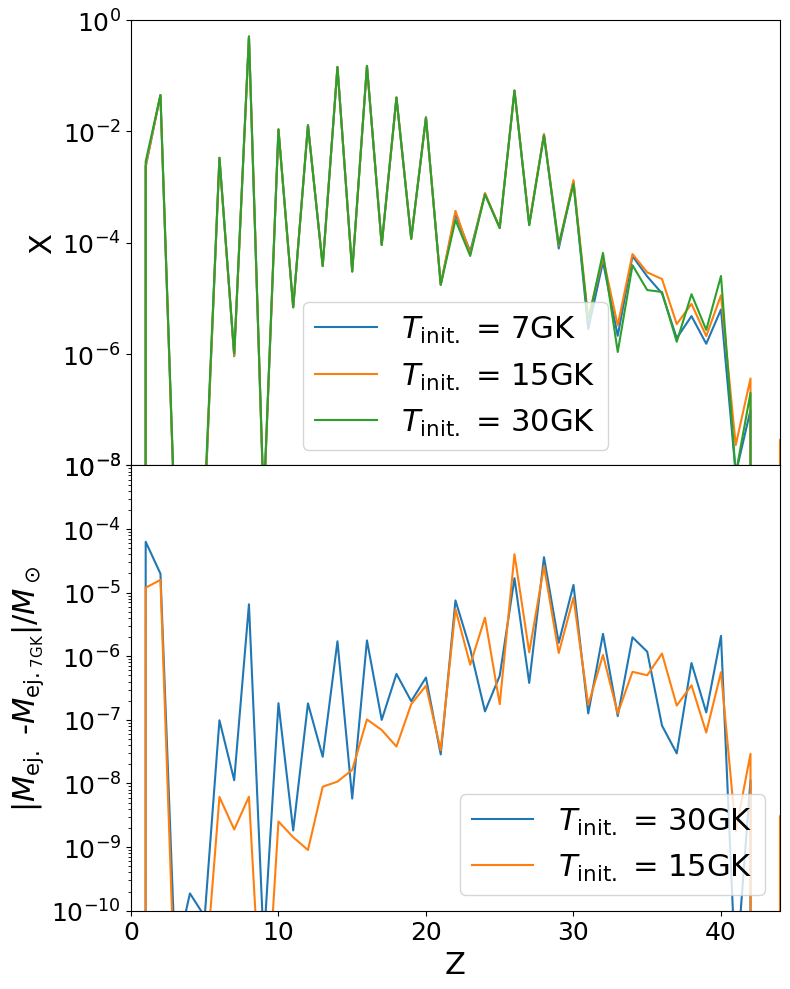

In [508]:
#multiplot
fig, ax = plt.subplots(2, 1, figsize=(8, 10), 
                       sharex=True, 
                       gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]})

# --- Top plot: absolute abundances ---
#2D_sampled
ax[0].plot(S15_10ktr_nf1_7GK_finabselem['Z'], S15_10ktr_nf1_7GK_finabselem['X_Z'], label = r'$T_\mathrm{init.}$ = 7GK')
ax[0].plot(S15_10ktr_nf1_15GK_finabselem['Z'], S15_10ktr_nf1_15GK_finabselem['X_Z'], label = r'$T_\mathrm{init.}$ = 15GK')
ax[0].plot(S15_10ktr_nf1_30GK_finabselem['Z'], S15_10ktr_nf1_30GK_finabselem['X_Z'], label = r'$T_\mathrm{init.}$ = 30GK')

ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1)
ax[0].set_ylabel('X', fontsize = 22)
ax[0].legend(fontsize = 22)
ax[0].set_xlim(0, 44)
ax[0].tick_params(labelsize = 18)

# --- Bottom plot: ratios vs 10k ---
x =  S15_10ktr_nf1_7GK_finabselem['Z']
denom =  S15_10ktr_nf1_7GK_finabselem['X_Z']


def pad_to_length(arr, length):
    if len(arr) == length:
        return arr
    if len(arr) < length:
        return np.pad(arr, (0, length - len(arr)), constant_values=0.0)
    # if arr is longer (shouldn't happen), trim it
    return arr[:length]

D = len(denom)

num1 = pad_to_length(S15_10ktr_nf1_15GK_finabselem['X_Z'], D)
y1 = np.divide(num1, denom, out=np.full_like(denom, np.nan), where=denom!=0)
#ax[1].plot(x, y1, label='15GK/7GK')

num2 = pad_to_length(S15_10ktr_nf1_30GK_finabselem['X_Z'], D)
y2 = np.divide(num2, denom, out=np.full_like(denom, np.nan), where=denom!=0)
#ax[1].plot(x, y2, label='30GK/7GK')

ax[1].plot(x, np.abs(S15_10ktr_nf1_30GK_finabselem['M_Z'] - S15_10ktr_nf1_7GK_finabselem['M_Z'])/M_sun_g, label = r'$T_\mathrm{init.}$ = 30GK')
ax[1].plot(x, np.abs(S15_10ktr_nf1_15GK_finabselem['M_Z'] - S15_10ktr_nf1_7GK_finabselem['M_Z'])/M_sun_g, label = r'$T_\mathrm{init.}$ = 15GK')

ax[1].set_xlabel('Z', fontsize = 22)
ax[1].set_ylabel(r'|$M_\mathrm{ej.}$ -$M_\mathrm{ej._{7GK}}$|/$M_\odot$', fontsize = 22)
#ax[1].set_ylabel(r'$X_{\mathrm{T}} / X_{7\,GK}$', fontsize = 22)
ax[1].legend( fontsize = 22)
ax[1].set_xlim(0, 44)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-10, 1e-3)
ax[1].tick_params(labelsize = 18)


plt.tight_layout()
#plt.savefig('../plots_movies/plots/Master_Thesis/T_init_comp.pdf')
plt.show()


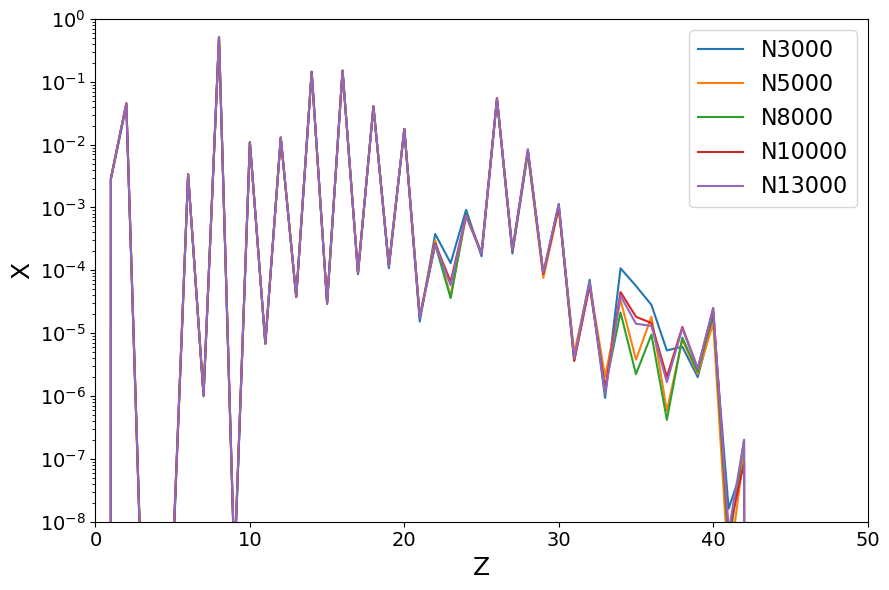

In [420]:
#finabs of Z plot:
plt.figure(figsize = (9,6))


#2D_sampled
plt.plot(sampled_S15_3ktr_nf1_30GK_out[2]['Z'], sampled_S15_3ktr_nf1_30GK_out[2]['X_Z'], label = 'N3000')
plt.plot(sampled_S15_5ktr_nf1_30GK_out[2]['Z'], sampled_S15_5ktr_nf1_30GK_out[2]['X_Z'], label = 'N5000')
plt.plot(sampled_S15_8ktr_nf1_30GK_out[2]['Z'], sampled_S15_8ktr_nf1_30GK_out[2]['X_Z'], label = 'N8000')
plt.plot(sampled_S15_10ktr_nf1_30GK_out[2]['Z'], sampled_S15_10ktr_nf1_30GK_out[2]['X_Z'], label = 'N10000')

#2D original full 13ktr run
plt.plot(S15_10ktr_nf1_30GK_out[2]['Z'], S15_10ktr_nf1_30GK_out[2]['X_Z'], label = 'N13000')

plt.xlabel('Z', fontsize = 18)
plt.ylabel(r'X', fontsize = 18)
plt.ylim(1e-8, 1)
plt.xlim(0, 50)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

#plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/Master_Thesis/integratedYields_Ntracer_comparison.png')

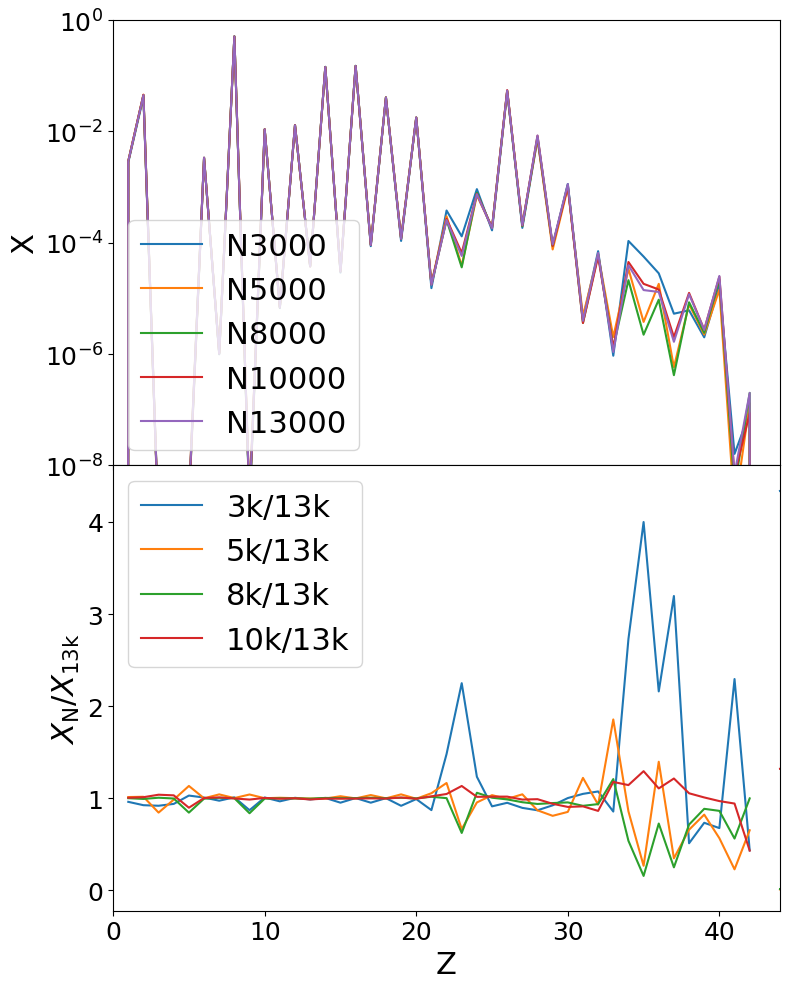

In [486]:
#multiplot
fig, ax = plt.subplots(2, 1, figsize=(8, 10), 
                       sharex=True, 
                       gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]})

# --- Top plot: absolute abundances ---
#2D_sampled
ax[0].plot(sampled_S15_3ktr_nf1_30GK_out[2]['Z'], sampled_S15_3ktr_nf1_30GK_out[2]['X_Z'], label = 'N3000')
ax[0].plot(sampled_S15_5ktr_nf1_30GK_out[2]['Z'], sampled_S15_5ktr_nf1_30GK_out[2]['X_Z'], label = 'N5000')
ax[0].plot(sampled_S15_8ktr_nf1_30GK_out[2]['Z'], sampled_S15_8ktr_nf1_30GK_out[2]['X_Z'], label = 'N8000')
ax[0].plot(sampled_S15_10ktr_nf1_30GK_out[2]['Z'], sampled_S15_10ktr_nf1_30GK_out[2]['X_Z'], label = 'N10000')

#2D original full 13ktr run
ax[0].plot(S15_10ktr_nf1_30GK_out[2]['Z'], S15_10ktr_nf1_30GK_out[2]['X_Z'], label = 'N13000')


ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1)
ax[0].set_ylabel('X', fontsize = 22)
ax[0].legend(fontsize = 22)
ax[0].set_xlim(0, 44)
ax[0].tick_params(labelsize = 18)

# --- Bottom plot: ratios vs 10k ---
x =  S15_10ktr_nf1_30GK_out[2]['Z']
denom =  S15_10ktr_nf1_30GK_out[2]['X_Z']


def pad_to_length(arr, length):
    if len(arr) == length:
        return arr
    if len(arr) < length:
        return np.pad(arr, (0, length - len(arr)), constant_values=0.0)
    # if arr is longer (shouldn't happen), trim it
    return arr[:length]

D = len(denom)

num1 = pad_to_length(sampled_S15_3ktr_nf1_30GK_out[2]['X_Z'], D)
y1 = np.divide(num1, denom, out=np.full_like(denom, np.nan), where=denom!=0)
ax[1].plot(x, y1, label='3k/13k')

num2 = pad_to_length(sampled_S15_5ktr_nf1_30GK_out[2]['X_Z'], D)
y2 = np.divide(num2, denom, out=np.full_like(denom, np.nan), where=denom!=0)
ax[1].plot(x, y2, label='5k/13k')

num3 = pad_to_length(sampled_S15_8ktr_nf1_30GK_out[2]['X_Z'], D)
y3 = np.divide(num3, denom, out=np.full_like(denom, np.nan), where=denom!=0)
ax[1].plot(x, y3, label='8k/13k')

num4 = pad_to_length(sampled_S15_10ktr_nf1_30GK_out[2]['X_Z'], D)
y4 = np.divide(num4, denom, out=np.full_like(denom, np.nan), where=denom!=0)
ax[1].plot(x, y4, label='10k/13k')


ax[1].set_xlabel('Z', fontsize = 22)
ax[1].set_ylabel(r'$X_{\mathrm{N}} / X_{13\mathrm{k}}$', fontsize = 22)
ax[1].legend( fontsize = 22)
ax[1].set_xlim(0, 44)
ax[1].tick_params(labelsize = 18)


plt.tight_layout()
plt.savefig('../plots_movies/plots/Master_Thesis/tracer#_comparison.pdf')
plt.show()


#### plotting S15 1Ds vs 2D

In [ ]:
#finabs of Z plot:
plt.figure(figsize = (9,6))

#1D
plt.plot(S15_750tr_1D_nf1_7GK_finabselem['Z'], S15_750tr_1D_nf1_7GK_finabselem['X_Z'], label = '1D')

#2D_1ktr
plt.plot(S15_1ktr_nf1_7GK_finabselem['Z'], S15_1ktr_nf1_7GK_finabselem['X_Z'], label = '2D, N3000')

#2D_10ktr
plt.plot(S15_10ktr_nf1_7GK_finabselem['Z'], S15_10ktr_nf1_7GK_finabselem['X_Z'], label = '2D, N13000')

plt.xlabel('Z', fontsize = 18)
plt.ylabel(r'X', fontsize = 18)
plt.ylim(1e-8, 1)
plt.xlim(0, 50)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

##### S15 dim vergleich integrated abundances vs A

In [ ]:
#finabs of Z plot:
plt.figure(figsize = (9,6))

#1D
plt.plot(S15_750tr_1D_nf1_7GK_finabs['A'], S15_750tr_1D_nf1_7GK_finabs['X'], label = '1D')

#2D_1ktr
plt.plot(S15_1ktr_nf1_7GK_finabs['A'], S15_1ktr_nf1_7GK_finabs['X'], label = '2D, N3000')

#2D_10ktr
plt.plot(S15_10ktr_nf1_7GK_finabs['A'], S15_10ktr_nf1_7GK_finabs['X'], label = '2D, N13000')

plt.xlabel('A', fontsize = 22)
plt.ylabel(r'X', fontsize = 22)
plt.ylim(1e-8, 1)
plt.xlim(0, 110)
plt.legend(fontsize = 22)
plt.tight_layout()
plt.yscale('log')

plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()


## 2) Composition and Conditions of the ejecta at NSE freeze out

Here: NSE_temp = 5.8GK

In [ ]:
nse_temp = 5.8e9 #K


#WinNet_Output objects now have an internal funtion self.get_Ye_at_freezeout and get_entr_at_freezeout which makes this easier (just loop over tracers of the clean set)
def quants_at_freezeout(clean_paths_WN_out, list_of_quants, NSE_temp = 5.8e9, want_paths = False):
    masses = []
    freezeout_vals = {key: [] for key in list_of_quants}
    paths = []
    
    for path in tqdm(clean_paths_WN_out):

        obj = WinNet_output(path, want_tracer_info=True)
        
        tr_dat = obj.tracer_data
        units = obj.tracer_data_units

        # Handle 'temp' or 'T'
        if "temp" in tr_dat:
            temp_key = "temp"
        elif "T" in tr_dat:
            temp_key = "T"
        else:
            print("No valid temperature key ('temp' or 'T') in tracer_data")
            continue
        
        # Unit conversion
        if units.get(temp_key, None) == "GK":
            temp_fac = 1e9
        elif units.get(temp_key, None) == "K":
            temp_fac = 1
        else:
            temp_fac = 0
            print("what kinda temperature unit is this :(")

        temps = tr_dat[temp_key] * temp_fac

        if np.max(temps) < NSE_temp:
            continue

        # Find last index where temp drops below NSE_temp
        crosses_NSE_at = np.where((temps[:-1] >= NSE_temp) & (temps[1:] < NSE_temp))[0] + 1

        if len(crosses_NSE_at) == 0:
            # never crossed NSE freezeout
            continue

        final_NSE_freezeout_idx = crosses_NSE_at[-1]
        masses.append(obj.mass)
        paths.append(path)

        for key in list_of_quants:
            freezeout_vals[key].append(np.array(tr_dat[key][final_NSE_freezeout_idx])) #if doesn work - remove np.array(...)

    if want_paths:
        return masses, freezeout_vals, paths
    else:
        return masses, freezeout_vals

In [ ]:
#fmts for different tracers:

#get freezeout vals of
vals_2Dfmt = ['ye', 'entr']
vals_1Dfmt = ['Ye', 'entr']

Ye_bins = np.linspace(0.35,0.65,51)
entr_bins = np.linspace(0, 50, 30)


#### S15

In [ ]:
S15_10ktr_nf1_7GK_masses, S15_10ktr_nf1_7GK_fovlas, S15_10ktr_nf1_7GK_NSEpaths = quants_at_freezeout(S15_10ktr_nf1_7GK_clean, vals_2Dfmt, want_paths=True) 

In [ ]:
S15_1D_nf1_7GK_masses, S15_1D_nf1_7GK_fo_vals = quants_at_freezeout(S15_750tr_1D_nf1_7GK_clean, vals_1Dfmt)

#### Plotting functions

In [ ]:
def Histo_plot(to_bin_list, bins, label_list, weights_list, xmin, xmax, xlabel, ylabel, save=False, save_name = None):
    plt.hist(to_bin_list, bins, label=label_list, weights=weights_list)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim(xmin, xmax)
    plt.legend(fontsize=16)
    plt.yscale('log')

    plt.tick_params(axis='both', labelsize=14) 
    
    if save and save_name is not None:
        plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/' + save_name )


#same but just to call in a multiplot:
def Histo_plot_for_multiplot(ax, to_bin_list, bins, label_list, weights_list, xmin, xmax, xlabel, ylabel):
    # plot on the given axes
    ax.hist(to_bin_list, bins=bins, label=label_list, weights=weights_list)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=16)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=14)

#custom colormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.colors as mcolors

# First, create the custom colormap
def create_jet_no_blue_colormap():
    """Create a jet-like colormap without the blue part"""
    # Get the full jet colormap
    jet_full = plt.get_cmap('jet')
    
    # Extract colors from 0.3 to 1.0 (removing the blue portion)
    # You can adjust these values if you want to remove more or less
    start_ratio = 0.35
    end_ratio = 1.0
    
    # Create new colormap
    jet_no_blue = ListedColormap(jet_full(np.linspace(start_ratio, end_ratio, 256)))
    
    return jet_no_blue

# Create the colormap
jet_no_blue = create_jet_no_blue_colormap()

#2D histo of sieverding:
def plot_2D_marginals(Ye, entropy, dm, num_bins=40, figsize=(7.5,6), cmap=None, 
                       Ye_min=None, Ye_max=None, entr_min=None, entr_max=None,
                       save=False, save_name=None):
    """
    Plots a 2D histogram with logarithmic marginal histograms.
    Marginal histograms touch the main plot with no gap.

    ALSO TAKES CUSTOM CMAP DEFINED ABOVE
    """
    Ye = np.array(Ye)
    entropy = np.array(entropy)
    dm = np.array(dm)

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[4,1.5], height_ratios=[1.5,4],
                  wspace=0, hspace=0)  # no space
    
    ax_main = fig.add_subplot(gs[1,0])
    ax_xhist = fig.add_subplot(gs[0,0], sharex=ax_main)
    ax_yhist = fig.add_subplot(gs[1,1], sharey=ax_main)
    
    # define bin edges
    if Ye_min is None: Ye_min = Ye.min()
    if Ye_max is None: Ye_max = Ye.max()
    if entr_min is None: entr_min = entropy.min()
    if entr_max is None: entr_max = entropy.max()

    Ye_edges = np.linspace(Ye_min, Ye_max, num_bins+1)
    entropy_edges = np.linspace(entr_min, entr_max, num_bins+1)

    # Use the custom colormap if none provided
    if cmap is None:
        cmap = jet_no_blue

    # 2D histogram
    hb = ax_main.hist2d(Ye, entropy, bins=[Ye_edges, entropy_edges], weights=dm, cmap=cmap,
                        norm=LogNorm())
    
    # marginal histograms
    ax_xhist.bar((Ye_edges[:-1] + Ye_edges[1:])/2,
                 np.histogram(Ye, bins=Ye_edges, weights=dm)[0],
                 width=np.diff(Ye_edges), edgecolor='blue')
    ax_yhist.barh((entropy_edges[:-1] + entropy_edges[1:])/2,
                  np.histogram(entropy, bins=entropy_edges, weights=dm)[0],
                  height=np.diff(entropy_edges), edgecolor='blue')
    
    # logarithmic scales for marginals
    ax_xhist.set_yscale('log')
    ax_yhist.set_xscale('log')
    
    # hide tick labels on marginals
    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    
    # increase font sizes
    label_fs = 22
    tick_fs = 16
    ax_main.set_xlabel(r"$Y_e$", fontsize=label_fs)
    ax_main.set_ylabel(r"Entropy [$k_\mathrm{B}$/baryon]", fontsize=label_fs)
    ax_xhist.set_ylabel(r"$M \,[M_\odot]$", fontsize=label_fs)
    ax_yhist.set_xlabel(r"$M \,[M_\odot]$", fontsize=label_fs)
    ax_main.tick_params(axis='both', labelsize=tick_fs)
    ax_xhist.tick_params(axis='y', labelsize=tick_fs)
    ax_yhist.tick_params(axis='x', labelsize=tick_fs)
    
    # set axis limits
    ax_main.set_xlim(Ye_min, Ye_max)
    ax_main.set_ylim(entr_min, entr_max)
    ax_xhist.set_xlim(Ye_min, Ye_max)
    ax_yhist.set_ylim(entr_min, entr_max)
    
    # remove top/bottom and left/right spines to make touching perfect
    ax_xhist.spines['bottom'].set_visible(False)
    ax_yhist.spines['left'].set_visible(False)

    # colorbar
    cbar = fig.colorbar(hb[3], ax=[ax_main, ax_xhist, ax_yhist], shrink=0.8, pad=0.05)
    cbar.set_label(r"$M\,[M_\odot]$", fontsize=label_fs)
    cbar.ax.tick_params(labelsize=tick_fs)
    
    if save and save_name is not None:
        plt.savefig("/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/" + save_name)
    
    plt.show()


#### dimension comparison - normal histograms

In [ ]:
Histo_plot([S15_2D_10ktr_nf0_10GK_fo_vals['ye'], S15_1D_nf0_10GK_fo_vals['Ye']], Ye_bins, ['2D', "1D"],
           [np.array(S15_2D_10ktr_nf0_10GK_masses)/sum(S15_2D_10ktr_nf0_10GK_masses),np.array(S15_1D_nf0_10GK_masses)/sum(S15_1D_nf0_10GK_masses)],
          0.4, 0.6, 'Ye', 'M/M_sum')

In [ ]:
Histo_plot([S15_2D_10ktr_nf0_10GK_fo_vals['entr'], S15_1D_nf0_10GK_fo_vals['entr']], entr_bins, ['2D', "1D"],
           [np.array(S15_2D_10ktr_nf0_10GK_masses)/sum(S15_2D_10ktr_nf0_10GK_masses),np.array(S15_1D_nf0_10GK_masses)/sum(S15_1D_nf0_10GK_masses)],
          0.0, 65, 'entr', 'M/M_sum')

In [ ]:
#next to each other: 

fig, ax = plt.subplots(1, 2, figsize = (13, 5), gridspec_kw={'wspace': 0})

Histo_plot_for_multiplot(ax[0], [S15_2D_10ktr_nf0_10GK_fo_vals['ye'], S15_1D_nf0_10GK_fo_vals['Ye']], Ye_bins, ['2D', "1D"],
           [np.array(S15_2D_10ktr_nf0_10GK_masses)/sum(S15_2D_10ktr_nf0_10GK_masses),np.array(S15_1D_nf0_10GK_masses)/sum(S15_1D_nf0_10GK_masses)],
          0.40, 0.6, 'Ye', r'M/$\Sigma \,$M')

Histo_plot_for_multiplot(ax[1], [S15_2D_10ktr_nf0_10GK_fo_vals['entr'], S15_1D_nf0_10GK_fo_vals['entr']], entr_bins, ['2D', "1D"],
           [np.array(S15_2D_10ktr_nf0_10GK_masses)/sum(S15_2D_10ktr_nf0_10GK_masses),np.array(S15_1D_nf0_10GK_masses)/sum(S15_1D_nf0_10GK_masses)],
          0.0, 65, r'entropy [$k_B$/baryon]', r'M/$\Eta$M')

ax[1].set_ylabel('')
ax[1].tick_params(labelleft=False)
ax[0].legend_.remove()
labels = [item.get_text() for item in ax[1].get_xticklabels()]
labels[0] = ''  # blank out the first label
ax[1].set_xticklabels(labels)

plt.tight_layout()

#plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/ye_entr_histo_2D(10ktr)_vs_1D.pdf')

#### Double Histogram from Sieverding Paper

##### S15

In [ ]:
plot_2D_marginals(S15_10ktr_nf1_7GK_fovlas['ye'], S15_10ktr_nf1_7GK_fovlas['entr'], 
                  dm=S15_10ktr_nf1_7GK_masses/M_sun_g)

In [ ]:
plot_2D_marginals(S15_1D_nf1_7GK_fo_vals['Ye'], S15_1D_nf1_7GK_fo_vals['entr'],
                  dm=S15_1D_nf1_7GK_masses/M_sun_g)

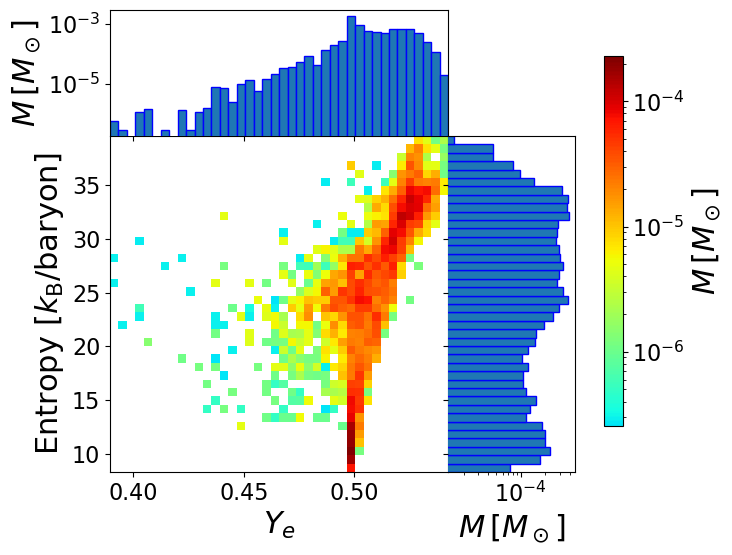

In [443]:
plot_2D_marginals(HeS_rn16_10k_nf1_7GK_fo_vals['ye'], HeS_rn16_10k_nf1_7GK_fo_vals['entr'], 
                  dm = HeS_rn16_10k_nf1_7GK_masses/M_sun_g, save = True, save_name = 'Master_Thesis/Sieverding_fig_HeS_rn16_10ktr.pdf')

## 3) Neutrino Processed Tracers

### Find the tracers with the most extreme ye values to further analyze in analyze_single notebook

In [ ]:
def find_tracers_with_val_in_interval(quants_at_freezeout, threshold_value_min, threshold_value_max):

    vals_list = []
    index_list = []
    
    for i, value in tqdm(enumerate(quants_at_freezeout)):
        if threshold_value_min < value < threshold_value_max:
            vals_list.append(value)
            index_list.append(i)

    if len(vals_list) == 0:
        print('No such tracers found')
    else:
        return np.array(vals_list), np.array(index_list)

In [ ]:
def find_tracers_in_ye_entr_intervals(ye_at_fo_arr, entr_at_fo_arr, ye_min, ye_max, entr_min, entr_max):
    ye_list = []
    entr_list = []
    index_list = []

    if len(ye_at_fo_arr) == len(entr_at_fo_arr):
        for i in range(len(ye_at_fo_arr)):
            if ye_min < ye_at_fo_arr[i] < ye_max and entr_min < entr_at_fo_arr[i] < entr_max:
                ye_list.append(ye_at_fo_arr[i])
                entr_list.append(entr_at_fo_arr[i])
                index_list.append(i)
    else:
        print("entr list and ye list have to be the same size")

    return np.array([np.array(ye_list), np.array(entr_list), np.array(index_list)])

#### S15: find one tracer per 'region'  in 2D histo: 1x n rich, 1x p rich high entr, one slighlty prich from bulk, one neutral low entr

In [ ]:
#find tracers from NSE-reaching tracers to look at individually from regions in the 2D histo:

ye_04_entr_28 = find_tracers_in_ye_entr_intervals(S15_10ktr_nf1_7GK_fovlas['ye'], S15_10ktr_nf1_7GK_fovlas['entr'], 0.35, 0.4, 25, 30)
ye_055_entr_48 = find_tracers_in_ye_entr_intervals(S15_10ktr_nf1_7GK_fovlas['ye'], S15_10ktr_nf1_7GK_fovlas['entr'], 0.55, 0.60, 45, 50)
ye_053_entr_35 = find_tracers_in_ye_entr_intervals(S15_10ktr_nf1_7GK_fovlas['ye'], S15_10ktr_nf1_7GK_fovlas['entr'], 0.52, 0.53, 36, 37)
ye_05_entr_10 = find_tracers_in_ye_entr_intervals(S15_10ktr_nf1_7GK_fovlas['ye'], S15_10ktr_nf1_7GK_fovlas['entr'], 0.495, 0.505, 0, 10)

In [ ]:
print(ye_04_entr_28)
print(ye_055_entr_48)
print(ye_053_entr_35[:,1])
print(ye_05_entr_10[:,0])

In [ ]:
#get paths to WinNet out for these - they will be analyzes in the analyse single Notebook/Plots for Master thesis
nurich_path = S15_10ktr_nf1_7GK_NSEpaths[25]
prich_high_entr = S15_10ktr_nf1_7GK_NSEpaths[818]
moderate_ye_and_entr = S15_10ktr_nf1_7GK_NSEpaths[169]
boring_one = S15_10ktr_nf1_7GK_NSEpaths[72]

print(nurich_path)
print(prich_high_entr)
print(moderate_ye_and_entr)
print(boring_one)

In [371]:
#ye_04_043_entr_10_20_S15_1k_nf1_10GK_oc = find_tracers_in_ye_entr_intervals(S15_1ktr_nf1_10GK_oc_freezeout_vals['ye'], S15_1ktr_nf1_10GK_oc_freezeout_vals['entr'], 0.4, 0.45, 20, 30) 

In [372]:
# #finds index in NSE paths
# print(ye_04_043_entr_10_20_S15_1k_nf1_10GK_oc[2])
# #get full path:
# print(S15_1ktr_nf1_10GK_oc_NSEpaths[13])
# print(S15_1ktr_nf1_10GK_oc_NSEpaths[171])

In [101]:
ye_tr_list = []
ye_mo_list = []
t0_30T9_list = []
t0_10T9_list = []
t0_7T9_list = []

for path in tqdm(nu_processed_paths):
    WN_out = WinNet_output(path, want_mainout_info=True,want_tracer_info=True)


    T = WN_out.tracer_data['temp']

    crossings7 = np.where((T[:-1] >= 7) & (T[1:] < 7))[0]
    last_7_idx = crossings7[-1] + 1 if crossings7.size > 0 else 0
    t0_7T9_list.append(WN_out.tracer_data['t'][last_7_idx])
    
    crossings10 = np.where((T[:-1] >= 10) & (T[1:] < 10))[0]
    last_10_idx = crossings10[-1] + 1 if crossings10.size > 0 else 0
    t0_10T9_list.append(WN_out.tracer_data['t'][last_10_idx])

    crossings30 = np.where((T[:-1] >= 30) & (T[1:] < 30))[0]
    last_30_idx = crossings30[-1] + 1 if crossings30.size > 0 else 0
    t0_30T9_list.append(WN_out.tracer_data['t'][last_30_idx])

    ye_tr_list.append([WN_out.tracer_data['t'], WN_out.tracer_data['ye']])
    ye_mo_list.append([WN_out.mainout_data['time'], WN_out.mainout_data['Ye']])

  0%|          | 0/1790 [00:00<?, ?it/s]

/home/bweinhold/Auswertung/2D_Analysis/nucleosynthesis_analysis/S15_Ritter_h10/new_S15_1ktr_bwd_nf1_7GK/00493


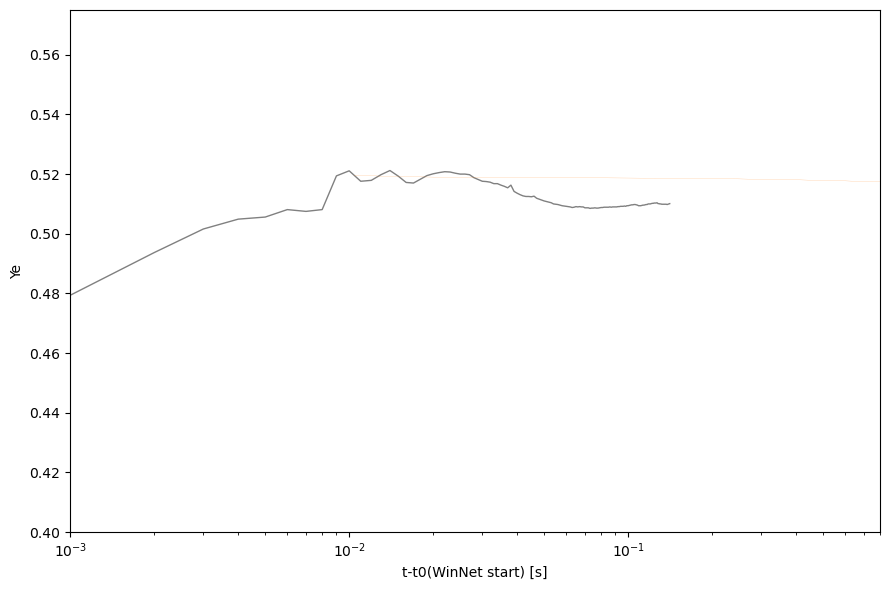

In [165]:
t0_list = t0_30T9_list

plt.figure(figsize = (9,6))


for tr_id in range(len(ye_tr_list)):

    if tr_id < start or tr_id > end:
        continue
    
    if t0_list[tr_id] == 0:
        continue
    # print(t0_list[tr_id])
    # print(ye_tr_list[tr_id][0]-t0_list[tr_id])
    plt.plot(ye_tr_list[tr_id][0]-t0_list[tr_id], ye_tr_list[tr_id][1], color = 'grey', linewidth = 1)
    plt.plot(ye_mo_list[tr_id][0]-t0_list[tr_id], ye_mo_list[tr_id][1], color = 'C1', linewidth = 0.1)

    print(nu_processed_paths[start])

plt.xlabel('t-t0(WinNet start) [s]')
plt.xscale('log')
plt.xlim(1e-3, 0.8)

plt.ylim(0.4, 0.575)
plt.ylabel('Ye')


plt.tight_layout()

start += 1 
end += 1

#plt.savefig('/home/bweinhold/Auswertung/2D_Analysis/plots_movies/plots/PfA_all_ye.png')

### These can now be closer inspected in analyze_single.ipynb